# 04 — Saturation (diminishing returns)

## Objective
Model diminishing returns in marketing response and evaluate how saturation
changes channel impact estimates compared to the adstock-only model.

## Inputs
- Weekly dataset with adstocked features from `03_adstock.ipynb`
- Selected baseline carryover assumption (theta)

## Output
- Saturated marketing features
- MMM with adstock + saturation
- Interpretation of diminishing returns by channel


## Why saturation

### Context
In reality, increasing marketing spend does not lead to proportional increases
in outcomes. Marginal returns typically decrease as spend grows.

### Decision
Apply a saturation transformation to adstocked spend variables.

### Rationale
Without saturation, MMM assumes linear scaling and may recommend unrealistic
allocations, concentrating budget in a single channel.


In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


In [2]:
target_col = "ALL_PURCHASES"
date_col = "DATE_DAY"

In [3]:
df_mmm = pd.read_csv("../data/processed/mmm_dataset_weekly_adstock.csv")

y = pd.read_csv("../data/processed/mmm_dataset_weekly_y_column.csv")
spend_cols = [c for c in df_mmm.columns if c.endswith("_SPEND")]



In [4]:
X_ads = df_mmm[spend_cols].copy()
y = y.copy()

X_ads.shape, y.shape

((251, 9), (251, 1))

## Saturation function

We use a Hill-type saturation function:

$f(x) = \frac{x^{\alpha}}{x^{\alpha} + k^{\alpha}}$

Where:
- $ x $ is the adstocked spend
- $ \alpha > 0 $ controls curve steepness
- $ k > 0 $ is the inflection point (half-saturation)

Properties:
- Increasing
- Bounded between 0 and 1
- Models diminishing marginal returns


In [5]:
def hill_saturation(x: np.ndarray, alpha: float, k: float) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    return (x ** alpha) / (x ** alpha + k ** alpha)


## Parameter choice (initial)

### Decision
Use a common saturation shape across channels as a starting point.

- alpha = 1.0
- k = median(adstocked spend per channel)

### Rationale
This choice provides a smooth, interpretable baseline and avoids overfitting
before validating sensitivity to saturation strength.


In [6]:
def safe_k_from_series(x: pd.Series, q: float = 0.5, eps: float = 1e-8) -> float:
    """
    Compute a robust k for Hill saturation.
    - Uses a quantile (default median) on positive values only.
    - Falls back to eps if the series has no positive values.
    """
    x_pos = x[x > 0]
    if len(x_pos) == 0:
        return eps
    k = float(x_pos.quantile(q))
    return max(k, eps)

alpha = 1.0
eps = 1e-8

X_sat = pd.DataFrame(index=X_ads.index)

k_by_channel = {}

for col in spend_cols:
    k = safe_k_from_series(X_ads[col], q=0.5, eps=eps)  # median of positive values
    k_by_channel[col] = k
    X_sat[col] = hill_saturation(X_ads[col].values, alpha=alpha, k=k)

# sanity check
X_sat.isna().sum().sort_values(ascending=False).head(10)


GOOGLE_PAID_SEARCH_SPEND    0
GOOGLE_SHOPPING_SPEND       0
GOOGLE_PMAX_SPEND           0
GOOGLE_DISPLAY_SPEND        0
GOOGLE_VIDEO_SPEND          0
META_FACEBOOK_SPEND         0
META_INSTAGRAM_SPEND        0
META_OTHER_SPEND            0
TIKTOK_SPEND                0
dtype: int64

In [7]:
# Adstock-only model
m_ads = LinearRegression().fit(X_ads, y)
pred_ads = m_ads.predict(X_ads)

# Adstock + saturation model
m_sat = LinearRegression().fit(X_sat, y)
pred_sat = m_sat.predict(X_sat)

metrics = pd.DataFrame({
    "model": ["adstock_only", "adstock_plus_saturation"],
    "r2": [r2_score(y, pred_ads), r2_score(y, pred_sat)],
    "mae": [mean_absolute_error(y, pred_ads), mean_absolute_error(y, pred_sat)],
})

metrics


,model,r2,mae
0,adstock_only,0.674539,28.024382
1,adstock_plus_saturation,0.564483,32.124767


## Why model fit decreases with saturation

Introducing saturation reduces in-sample model fit by design.

In the adstock-only model, the relationship between transformed spend and the
target remains linear:

$y_t = \beta_0 + \sum_c \beta_c \, \tilde{x}_{c,t} + \varepsilon_t$


This allows large values of adstocked spend to explain large variations in the
target through linear extrapolation.

When saturation is introduced, adstocked spend is replaced by a bounded
non-linear transformation $ f(\tilde{x}_{c,t}) \in [0, 1] $:

$y_t = \beta_0 + \sum_c \beta_c \, f(\tilde{x}_{c,t}) + \varepsilon_t$

As a consequence:
- The model loses the ability to fit extreme outcomes by extrapolating linearly.
- Variance explained in-sample may decrease.
- The model becomes more conservative and behaviorally realistic.

This degradation in fit reflects a deliberate modeling choice: prioritizing
economic plausibility and decision stability over in-sample goodness of fit.


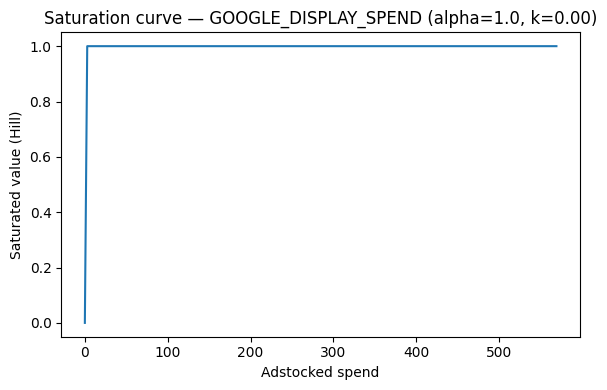

In [8]:
import matplotlib.pyplot as plt

channel = "GOOGLE_DISPLAY_SPEND"  # prueba también GOOGLE_PAID_SEARCH_SPEND
x_vals = np.linspace(0, X_ads[channel].max(), 200)

k = k_by_channel[channel]
y_vals = hill_saturation(x_vals, alpha=alpha, k=k)

plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals)
plt.xlabel("Adstocked spend")
plt.ylabel("Saturated value (Hill)")
plt.title(f"Saturation curve — {channel} (alpha={alpha}, k={k:.2f})")
plt.tight_layout()
plt.show()


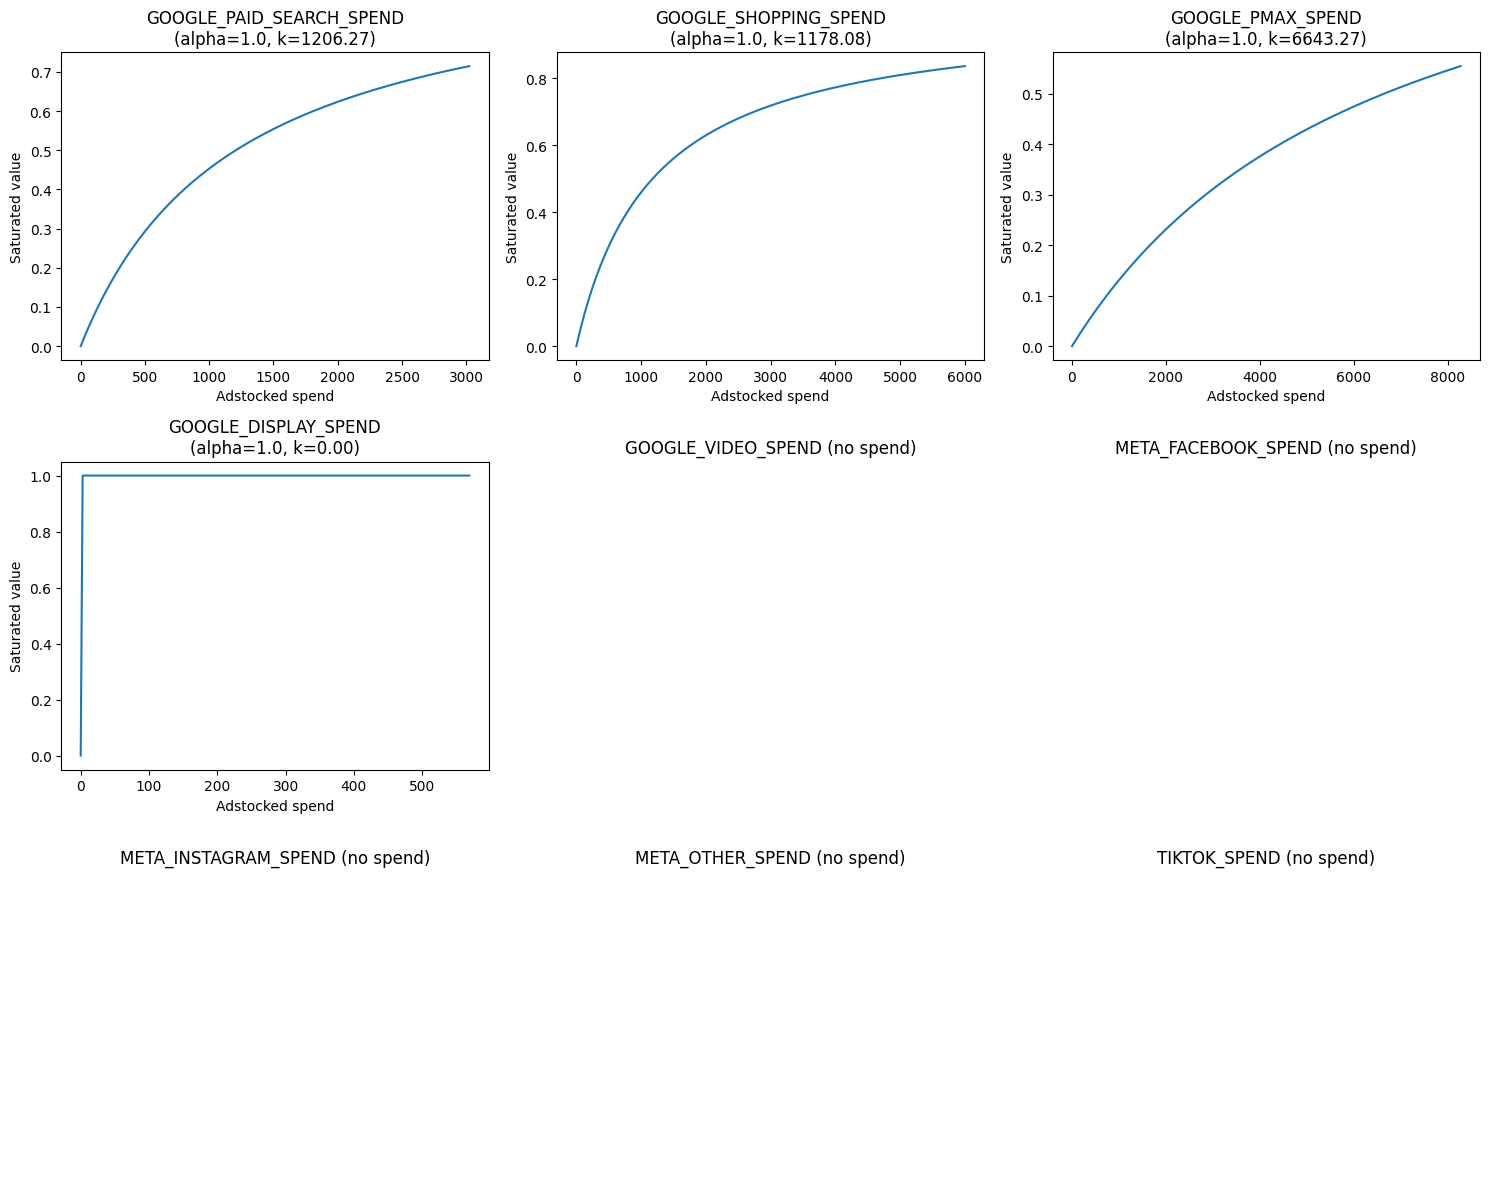

In [9]:
import matplotlib.pyplot as plt
import numpy as np

n_cols = 3
channels = spend_cols
n_rows = int(np.ceil(len(channels) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for ax, channel in zip(axes, channels):
    x_max = X_ads[channel].max()
    if x_max <= 0:
        ax.set_title(f"{channel} (no spend)")
        ax.axis("off")
        continue

    x_vals = np.linspace(0, x_max, 200)
    k = k_by_channel[channel]

    y_vals = hill_saturation(x_vals, alpha=alpha, k=k)

    ax.plot(x_vals, y_vals)
    ax.set_title(f"{channel}\n(alpha={alpha}, k={k:.2f})")
    ax.set_xlabel("Adstocked spend")
    ax.set_ylabel("Saturated value")

# Hide unused subplots
for ax in axes[len(channels):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


La saturación responde a la pregunta

¿Cuánto gasto necesito para alcanzar el 50% del efecto máximo?

## Interpretation of saturation curves

The saturation curves reveal substantial heterogeneity across channels:

- **Search-related channels (Paid Search, Shopping, PMax)** exhibit smooth,
  monotonically increasing curves with clear diminishing returns. This indicates
  that these channels support a meaningful saturation structure and that marginal
  efficiency decreases as spend increases.

- **Display** shows near-instant saturation with a very low half-saturation point.
  This behavior reflects data sparsity and limited signal rather than true business
  dynamics. As a result, saturation parameters for this channel should be treated
  with caution or informed by prior assumptions.

- **Other channels (Meta, TikTok, Video)** do not exhibit identifiable saturation
  behavior due to insufficient or highly sparse spend data.

Overall, these curves highlight that saturation effects are partly data-driven
and partly assumption-driven, and their interpretability depends strongly on
the richness of the underlying spend series.


## Mathematical interpretation of fit degradation

In the adstock-only model, the relationship between transformed spend and outcome
remains linear:

$y_t = \beta_0 + \sum_c \beta_c \, \tilde{x}_{c,t} + \varepsilon_t$

This allows large values of $\tilde{x}_{c,t}$ to explain large variations in $y_t$
without constraint.

Introducing saturation replaces $\tilde{x}_{c,t}$ with a bounded transformation
$f(\tilde{x}_{c,t}) \in [0, 1]$:

$y_t = \beta_0 + \sum_c \beta_c \, f(\tilde{x}_{c,t}) + \varepsilon_t$

As a consequence:
- The model loses the ability to fit extreme outcomes by extrapolating linearly.
- Variance explained in-sample may decrease.
- The model becomes more conservative and realistic in its response assumptions.

This trade-off reflects a deliberate modeling choice: prioritizing behavioral realism
over in-sample goodness of fit.


In [12]:


# Ensure y is 1D
y_1d = np.asarray(y).ravel()

alphas = [0.5, 0.8, 1.0, 1.5, 2.0]

rows = []
coef_rows = []

for alpha in alphas:
    X_sat_alpha = pd.DataFrame(index=X_ads.index)

    for col in spend_cols:
        k = k_by_channel[col]
        X_sat_alpha[col] = hill_saturation(X_ads[col].values, alpha=alpha, k=k)

    # Fit model
    m = LinearRegression().fit(X_sat_alpha, y_1d)
    pred = m.predict(X_sat_alpha)

    rows.append({
        "alpha": alpha,
        "r2": r2_score(y_1d, pred),
        "mae": mean_absolute_error(y_1d, pred)
    })

    # Handle coef_ shape robustly
    coef = np.asarray(m.coef_).ravel()  # ensure 1D
    coefs = pd.Series(coef, index=X_sat_alpha.columns, name=alpha)
    coef_rows.append(coefs)

metrics_alpha = pd.DataFrame(rows).sort_values("alpha")
coef_alpha = pd.DataFrame(coef_rows)

display(metrics_alpha)
display(coef_alpha)


,alpha,r2,mae
0,0.5,0.430683,36.375073
1,0.8,0.515543,33.845682
2,1.0,0.564483,32.124767
3,1.5,0.645259,28.978572
4,2.0,0.685681,27.361872


,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND
0.5,229.793230,88.601108,238.737437,-30.149546,0.0,0.0,0.0,0.0,0.0
0.8,123.682037,135.855205,295.058095,-19.637087,0.0,0.0,0.0,0.0,0.0
1.0,92.510374,148.135889,315.390537,-14.393793,0.0,0.0,0.0,0.0,0.0
1.5,58.336165,149.860859,333.189142,-7.487562,0.0,0.0,0.0,0.0,0.0
2.0,44.879386,141.071758,332.776943,-5.740698,0.0,0.0,0.0,0.0,0.0


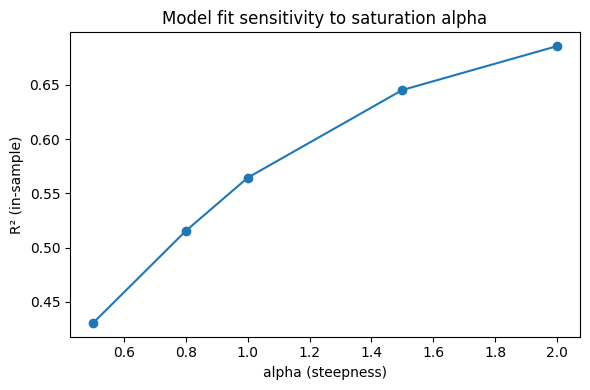

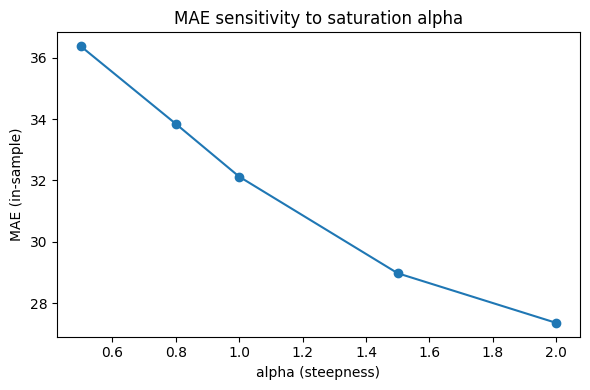

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(metrics_alpha["alpha"], metrics_alpha["r2"], marker="o")
plt.xlabel("alpha (steepness)")
plt.ylabel("R² (in-sample)")
plt.title("Model fit sensitivity to saturation alpha")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(metrics_alpha["alpha"], metrics_alpha["mae"], marker="o")
plt.xlabel("alpha (steepness)")
plt.ylabel("MAE (in-sample)")
plt.title("MAE sensitivity to saturation alpha")
plt.tight_layout()
plt.show()


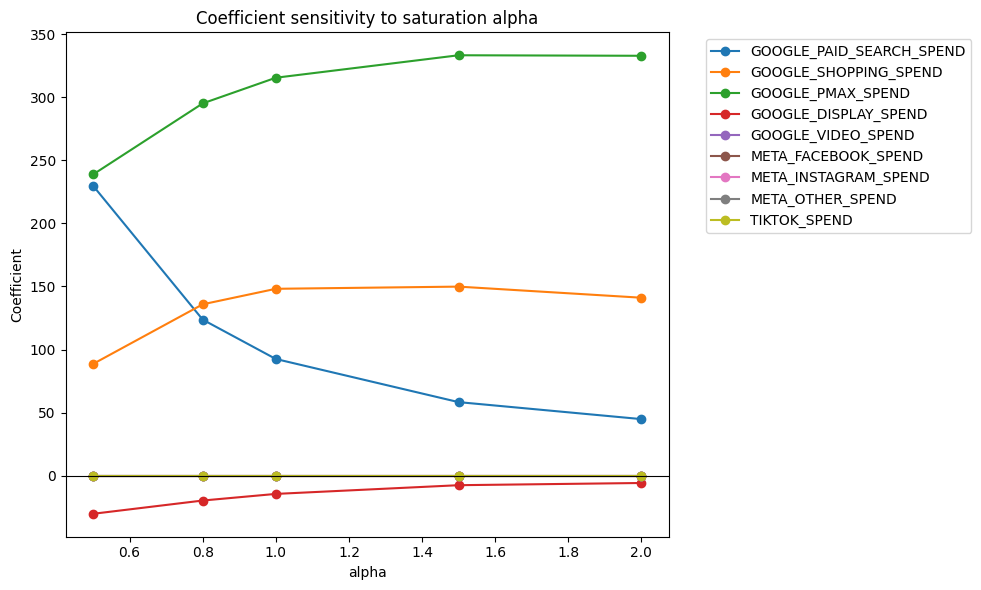

In [14]:
coef_long = (
    coef_alpha
    .reset_index(drop=False)
    .rename(columns={"index": "alpha"})
    .melt(id_vars="alpha", var_name="channel", value_name="coef")
)

plt.figure(figsize=(10, 6))
for ch in coef_long["channel"].unique():
    sub = coef_long[coef_long["channel"] == ch]
    plt.plot(sub["alpha"], sub["coef"], marker="o", label=ch)

plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("alpha")
plt.ylabel("Coefficient")
plt.title("Coefficient sensitivity to saturation alpha")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Interpretation of alpha sensitivity

Model fit improves monotonically as alpha increases:
- R² increases from ~0.43 (alpha = 0.5) to ~0.69 (alpha = 2.0)
- MAE decreases accordingly

This behavior is expected: higher alpha values produce steeper saturation curves,
which allow the model to better fit in-sample variation by concentrating impact
around higher spend levels.


### Coefficient stability

As alpha increases:
- Search coefficients decrease sharply
- PMax coefficients increase substantially
- Shopping stabilizes around alpha ≈ 1.0–1.5
- Display remains weak and negative, reflecting limited identifiability

While coefficients remain stable in sign, their magnitude changes materially,
especially at extreme alpha values.


## Interpretation (alpha sensitivity)

Alpha controls the *steepness* of the saturation curve:
- Lower alpha (e.g., 0.5) produces smoother, more gradual diminishing returns.
- Higher alpha (e.g., 2.0) produces sharper saturation, closer to an “all-or-nothing” response.

In practice, we prefer alpha values that:
- produce stable coefficients across nearby values
- avoid extreme behavior (very sharp saturation)
- lead to plausible channel rankings and contributions


## Decision

Select a baseline saturation steepness:
- Baseline alpha: <to be chosen based on sensitivity results>

## Rationale

The chosen alpha provides a good balance between realism and stability:
- coefficients remain stable across nearby alpha values
- saturation is neither unrealistically mild nor overly abrupt
- results remain interpretable for scenario analysis


## Why higher alpha improves in-sample fit

The Hill saturation function becomes increasingly steep as alpha grows:

$f(x) = \frac{x^{\alpha}}{x^{\alpha} + k^{\alpha}}$

As \( \alpha \to \infty \), the function approaches a step function centered at \( k \).
This allows the model to approximate threshold-like behavior and fit in-sample data
more closely.

However, this comes at a cost:
- Increased sensitivity to noise
- Reduced smoothness of marginal response
- Higher risk of overfitting


## Decision

Select a moderate saturation steepness:
- **Baseline alpha: 1.0**

## Rationale

Alpha = 1.0 provides a balanced trade-off:
- Introduces diminishing returns without extreme curvature
- Produces stable coefficients across nearby values
- Avoids step-like behavior observed at high alpha
- Maintains interpretability for scenario analysis

Although higher alpha values improve in-sample fit, they introduce sharper
non-linearities that are less robust and harder to justify from a business
perspective.


In [17]:
X_sat.to_csv("../data/processed/mmm_dataset_weekly_saturation.csv",index=False)